Candidate Data Selection
===

Requirement for users:
 - 2+ updates authored at least 24 hours apart
 - Never authored an update on a spam site

Requirements for sites:
 - Non-spam
 - At least one update from a candidate user
 - Maybe: 2+ updates (are there sites that meet other criteria and only have 1 update? Answer: yes, many. We will NOT use this requirement.)
 
This version uses the new sources of replies, journals, and site data.
 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
# this imports a number of utility functions related to data annotation & the web client
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils
import db as db_utils

In [4]:
# put all derived data in the data_selection folder
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
os.makedirs(working_dir, exist_ok=True)

In [5]:
# load the site metadata dataframe
# this is created in caringbridge_core from the new data
site_metadata_working_dir = "/home/srivbane/shared/caringbridge/data/derived/site_metadata"
s = datetime.now()
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_info_df = pd.read_feather(site_metadata_filepath)
print(datetime.now() - s)
len(site_info_df)

0:00:04.449114


840943

In [ ]:
site_info_df.head()

In [7]:
# load the journal dataframe with the index
# this is all the new journal data
s = datetime.now()
journal_metadata_dir = "/home/srivbane/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:25.513279


17893390

In [8]:
journal_df.head()

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True
3,1104461640000,51bdf3e56ca0048f4e00cece,0,1,1104461640000,1,3,True
4,1104807180000,51bdf3e56ca0048f4e00cecc,0,1,1104807180000,1,4,True


In [9]:
# the vast majority of sites with journals also have site-level metadata
# these 11 missing sites might be related to e.g. incomplete deletions on the part of CaringBridge
len(set(journal_df.site_id) - set(site_info_df.site_id))

11

In [10]:
# trim out journal updates that are trivial (short or machine-generated)
journal_df = journal_df[journal_df.is_nontrivial]
len(journal_df)

17450827

In [11]:
# build a dataframe where each site has a list of user_ids on that site and the total number of non-trivial journals
site_proportions = []
for site_id, group in tqdm(journal_df.groupby(by='site_id', sort=False)):
    total_journals = len(group)
    user_ids = set(group.user_id)
    site_proportion = {
        'site_id': site_id,
        'user_ids': user_ids,
        'total_journals': total_journals
    }
    site_proportions.append(site_proportion)
len(site_proportions)

100%|██████████| 605630/605630 [03:27<00:00, 2919.28it/s]


605630

In [12]:
site_proportions_df = pd.DataFrame(site_proportions)
len(site_proportions_df)

605630

In [13]:
# merge the dataframes so that we have more detailed site-level info
s = datetime.now()
site_df = pd.merge(site_info_df, site_proportions_df, on='site_id', validate='one_to_one')
print(datetime.now() - s)
len(site_df), len(site_df) / len(site_info_df), len(site_df) / len(site_proportions_df)

0:00:02.358875


(605628, 0.7201772296100925, 0.9999966976536829)

In [ ]:
site_df.head()

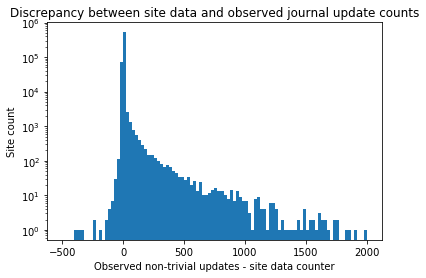

In [15]:
# note that in many cases there is a discrepency between the site-metadata counter of journals the observed non-trivial journal count
plt.hist(site_df.total_journals - site_df.numJournals, log=True, bins=100, range=(-500,2000))
plt.title("Discrepancy between site data and observed journal update counts")
plt.xlabel("Observed non-trivial updates - site data counter")
plt.ylabel("Site count")
plt.show()

In [16]:
site_df.dtypes

age                         object
created_at                   int64
hasVisitorInvite            object
healthCondition_category    object
healthCondition_custom      object
healthCondition_name        object
ip                          object
isDeleted                   object
isForSelf                   object
isGoogleable                object
isSearchable                object
isSpam                      object
location_address            object
location_city               object
location_country            object
location_state              object
name                        object
numAmps                      int64
numAuthorInvites             int64
numCoAuthors                 int64
numGuestbooks                int64
numJournalDrafts             int64
numJournals                  int64
numLinks                     int64
numPhotos                    int64
numTasks                     int64
numTributes                  int64
numVisitorInvites            int64
privacy             

In [ ]:
site_df.head()

In [18]:
journal_df.head()

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True
3,1104461640000,51bdf3e56ca0048f4e00cece,0,1,1104461640000,1,3,True
4,1104807180000,51bdf3e56ca0048f4e00cecc,0,1,1104807180000,1,4,True


## User filtering

In [19]:
# now we apply the user filtering conditions
jan_1995 = 788918400000
july_2016 = 1467331200000
hours_24 = 1000 * 60 * 60 * 24

valid_users = set()

invalid_early_date_count = 0
invalid_future_date_count = 0
not_active_enough_count = 0
only_in_new_data_count = 0  # counts the number of user who made their first post after the end (June 2016) of the old dataset

for user_id, updates in tqdm(journal_df.groupby(by='user_id', sort=False)):
    first_update = np.min(updates.created_at)
    last_update = np.max(updates.created_at)
    if first_update < jan_1995:
        invalid_early_date_count += 1
    if last_update > july_2016:
        invalid_future_date_count += 1
        #raise ValueError(f"Unexpected date in the future for user {user_id}: {last_update} ({str(datetime.fromtimestamp(last_update / 1000))})")
    if first_update > july_2016:
        only_in_new_data_count += 1
        continue
    if last_update - first_update <= hours_24:
        # note that this also trims out users with only 1 journal update
        not_active_enough_count += 1
        continue
    valid_users.add(user_id)
len(valid_users), len(valid_users) / len(set(journal_df.user_id))

100%|██████████| 667575/667575 [05:30<00:00, 2017.83it/s]


(373147, 0.5589589184735797)

In [20]:
invalid_early_date_count, invalid_future_date_count, not_active_enough_count, only_in_new_data_count

(213, 165723, 162334, 132094)

In [21]:
0 in valid_users

True

In [22]:
valid_users.remove(0)

In [23]:
removed_for_spam = 0
for spam_users in tqdm(site_df[~site_df.isSpam.isna()].user_ids):
    for spam_user in spam_users:
        if spam_user in valid_users:
            valid_users.remove(spam_user)
            removed_for_spam += 1
removed_for_spam, len(valid_users)

100%|██████████| 90444/90444 [00:00<00:00, 1150370.51it/s]


(10776, 362370)

In [24]:
# Manual removal of users who are invalid for other reasons
invalid_users = [
    15159562,  # Test user account run by CaringBridge Customer Experience team
    46,  # Seems to be run at least in part by CaringBridge team for testing
    13896060,  # Seems like another customer care rep
    594,  # Seems like a customer care rep, but also seems like it may include some legitimate sites? (see e.g. site 559205)
    7393709, #Junk and test posts
    25036137, #Repeated test text
    8192483, #Mostly test posts, but one genuine post about patient
    17956362, #Test posts
    16648084, #Test posts (and some good poetry)
    31761432, # Doctor's ad
    32764680, # Payday lending ad
    30457719, # 3D visualization company ad
    32538830, # Car supplies ad
    32757690, # Fashion ad
    32757739, # Clothing brand ad
    1043681, # Leasing furniture ad
    28132146, # Farm company ad
    31477721, # Lenders ad
    31879875, # Payday lender ad
    31799168, # Credit company ad
    32428328, # SEO ad
    31684805, # Various ads
    30165532, # Various ads about black magic
    31833912, # Job hunting spam
    32753111, # Arabic text (possibly spam)
    32732132 # Turkish text (spam)
]

In [25]:
removed_manually = 0
for invalid_user in invalid_users:
    if invalid_user in valid_users:
        valid_users.remove(invalid_user)
        removed_manually += 1
removed_manually, len(valid_users)

(25, 362345)

In [26]:
# what percent of users remain?
len(valid_users) / len(set(journal_df.user_id))

0.5427779650226566

In [27]:
# write out valid users to text file
with open(os.path.join(working_dir, "valid_user_ids.txt"), 'w') as outfile:
    for user_id in valid_users:
        outfile.write(str(user_id) + "\n")
print("Finished.")

Finished.


In [28]:
# read valid users
valid_users = set()
with open(os.path.join(working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_users.add(int(user_id))
len(valid_users)

362345

## Site analysis & filtering

In [29]:
site_df.user_ids.iloc[0]

{7168884}

In [30]:
valid_site_ids = set()
for site_id, author_user_ids in zip(site_df.site_id, site_df.user_ids):
    if len(author_user_ids & valid_users) >= 1:
        valid_site_ids.add(site_id)

In [31]:
len(valid_site_ids), len(valid_site_ids) / len(set(site_df.site_id))

(340414, 0.562084315784607)

In [32]:
# are there any spam sites still in the sample?
# no, as expected
len(site_df[(~site_df.isSpam.isna())&(site_df.site_id.isin(valid_site_ids))])

0

In [33]:
# how many sites included in this sample have only a single (substantive) update?
# note that these sites necessarily imply a multi-site-authorship situation
total_single_update_sites = len(site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.total_journals == 1)])
total_single_update_sites, total_single_update_sites / len(valid_site_ids)

(7090, 0.0208275805342906)

In [34]:
single_update_site_ids = np.array(site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.total_journals == 1)].site_id)
len(single_update_site_ids)

7090

In [35]:
# write out valid sites to text file
with open(os.path.join(working_dir, "valid_site_ids.txt"), 'w') as outfile:
    for site_id in valid_site_ids:
        outfile.write(str(site_id) + "\n")
print("Finished.")

Finished.


In [36]:
# read valid sites
valid_site_ids = set()
with open(os.path.join(working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

#### Analysis of single-update sites

In [26]:
np.random.choice(single_update_site_ids, size=10)

array([ 967272, 1088480,  946630, 1114463, 1077345,  864816, 1154454,
        250808,  206138, 1069245])

In [ ]:
# patient site
# spam
# strange caregiver site about high-risk pregnancy
# spam
# spam, but weird spam
# patient site
# 1154454 no visible journal update (update in new journal only)
# caregiver site
# caregiver site
# spam

#### The analysis below was conducted on the old dataset

A similar analysis is repeated above.

In [31]:
np.random.choice(single_update_site_ids, size=10)

array([1109221,  316814,  334144, 1105577,   32272,  821062, 1048160,
        910206, 1114694, 1111885])

In [32]:
# from the random sample above:
# 1 was a redirect, pointing to a new CB site
# 1 was a caregiver creating a funeral/notification post on behalf of another family
# 1 (site 431930) was a strange caregiver site that was never visited
# 1 (site 858957) was a bizarre personal post warning about friend betrayal. (6 visits)
# 1 (site 901250) was a normal single-update site from a parent about their child starting school
# the other 5 were spam sites (!!)

In [33]:
active_single_update_site_ids = np.array(site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.total_journals == 1)&(site_df.visits > 20)].site_id)
len(active_single_update_site_ids)

1312

In [34]:
np.random.choice(active_single_update_site_ids, size=10)

array([ 709747, 1111535,  873413,  662019,  150530,  634905,   11169,
        352727,  530533,  175638])

In [35]:
# 3 / 10 of the above active > 20 visit sites were spam

In [36]:
active_single_update_site_ids = np.array(site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.total_journals == 1)&(site_df.visits > 100)].site_id)
len(active_single_update_site_ids)

375

In [37]:
np.random.choice(active_single_update_site_ids, size=10)

array([ 886514,  103904,  839793, 1023559,  403792,   12750,  597009,
       1105530,  888444,  901060])

In [38]:
# 1 / 10 of the above active > 100 visit sites were spam

### Additional site analysis based on number of visits

In [45]:
# how many sites included in this sample have 0, 1, or <10 visits?
len(site_df[(site_df.visits == 0)&(site_df.site_id.isin(valid_site_ids))]), \
len(site_df[(site_df.visits == 1)&(site_df.site_id.isin(valid_site_ids))]), \
len(site_df[(site_df.visits <= 10)&(site_df.site_id.isin(valid_site_ids))]), \
len(site_df[(site_df.visits <= 100)&(site_df.site_id.isin(valid_site_ids))]) 

(6, 1811, 12916, 42567)

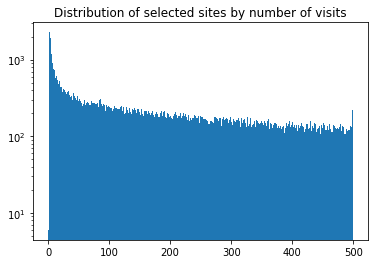

In [46]:
plt.hist(site_df[site_df.site_id.isin(valid_site_ids)].visits, log=True, bins=range(500))
plt.title("Distribution of selected sites by number of visits")
plt.show()

### Random selection of sites for author type annotation

In [34]:
annotation_assignment_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
annotators = ["levon003", "mill6273"]

In [32]:
valid_site_ids_arr = np.array(list(valid_site_ids))

In [33]:
initial_training_set = np.random.choice(valid_site_ids_arr, size=10)
validation_set = np.random.choice(valid_site_ids_arr, size=30)

In [36]:
assert False, "Don't rerun this cell without changing the filenames to generate NEW random samples from the valid sites!"
for annotator in annotators:
    user_annotation_dir = os.path.join(annotation_assignment_dir, annotator)
    fname = "sna_author_type_train_n10.txt"
    with open(os.path.join(user_annotation_dir, fname), 'w') as outfile:
        outfile.write("Site-level author type annotation (Train 1)\n")
        for site_id in initial_training_set:
            outfile.write(f"{site_id}\n")
    fname = "sna_author_type_valid_n30.txt"
    with open(os.path.join(user_annotation_dir, fname), 'w') as outfile:
        outfile.write("Site-level author type annotation (Validation 1)\n")
        for site_id in validation_set:
            outfile.write(f"{site_id}\n")
print("Finished.")

Finished.


#### Random selection of a subset of sites for author type annotation

We select sites with 10-20 updates and between 25-75% patient-authored.

In [30]:
annotation_assignment_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
annotators = ["levon003", "mill6273"]

In [33]:
# TODO need to load the author type classifier predictions before I can generate this subset of sites to annotate

In [ ]:
subset_site_ids = set()
subset_site_ids_arr = np.array(list(subset_site_ids))
initial_training_set = np.random.choice(subset_site_ids_arr, size=10)
validation_set = np.random.choice(subset_site_ids_arr, size=30)

In [36]:
assert False, "Don't rerun this cell without changing the filenames to generate NEW random samples from the valid sites!"
for annotator in annotators:
    user_annotation_dir = os.path.join(annotation_assignment_dir, annotator)
    fname = "sna_author_type_mixed_train_n10.txt"
    with open(os.path.join(user_annotation_dir, fname), 'w') as outfile:
        outfile.write("Site-level author type annotation on maybe ambiguous sites (Train 2)\n")
        for site_id in initial_training_set:
            outfile.write(f"{site_id}\n")
    fname = "sna_author_type_mixed_valid_n30.txt"
    with open(os.path.join(user_annotation_dir, fname), 'w') as outfile:
        outfile.write("Site-level author type annotation on maybe ambiguous sites (Validation 2)\n")
        for site_id in validation_set:
            outfile.write(f"{site_id}\n")
print("Finished.")

Finished.


### Multi-user site analysis

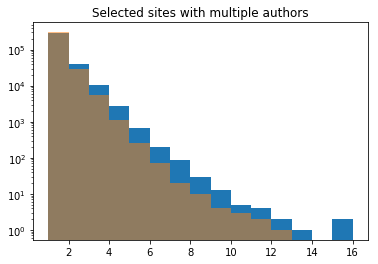

In [46]:
author_counts = np.array([len(user_ids) for user_ids in site_df[site_df.site_id.isin(valid_site_ids)].user_ids])
valid_author_counts = np.array([len(user_ids & valid_users) for user_ids in site_df[site_df.site_id.isin(valid_site_ids)].user_ids])
plt.hist(author_counts, log=True, bins=range(1,17))
plt.hist(valid_author_counts, log=True, bins=range(1,17), alpha=0.5)
plt.title("Selected sites with multiple authors")
plt.show()

In [50]:
# of the valid sites, 16% have multiple authors but only 10% have multiple VALID authors
np.sum(author_counts > 1) / len(author_counts), np.sum(valid_author_counts > 1) / len(valid_author_counts)

(0.160153636694405, 0.10537728430417484)

In [54]:
np.sum(valid_author_counts > 1)

35913

In [52]:
site_df['valid_author_counts'] = [len(user_ids & valid_users) for user_ids in site_df.user_ids]

In [55]:
sites_with_multiple_valid_authors = site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.valid_author_counts >= 2)].site_id
len(sites_with_multiple_valid_authors)

35913

In [56]:
np.random.choice(sites_with_multiple_valid_authors, size=10)

array([ 840336,  862570,  884170, 1051171, 1065938, 1035080,  683587,
        450675,  508079,  386061])

#### Multi-site users analysis

In [59]:
for user_id in tqdm(valid_users):
    res = site_df[(site_df.site_id.isin(valid_site_ids))&(site_df.user_ids.map(lambda user_id_list: user_id in user_id_list))]
    if len(res) > 1:
        # this author has written posts on multiple valid sites
        print(list(res.site_id))
        break
    #[user_id in user_ids for user_ids in site_df.user_ids]

  0%|          | 31/362370 [00:06<21:47:19,  4.62it/s]

[35, 146716]


In [ ]:
multisite_user_ids = set()
for user_id, journals in tqdm(journal_df[(journal_df.site_id.isin(valid_site_ids))&(journal_df.user_id.isin(valid_users))].groupby(by='user_id', sort=False)):
    user_site_ids = set(journals.site_id)
    if len(user_site_ids) >= 2:
        multisite_user_ids.add(user_id)
len(multisite_user_ids)

In [66]:
# 5% of valid users have authored updates on more than one site
len(multisite_user_ids) / len(valid_users)

0.05164886717995419

In [67]:
np.random.choice(list(multisite_user_ids), size=10)

array([20594755,   276435, 29470066,  2909494, 30423617,  6041707,
        4151269, 11222832,  5098450,  9739758])

### Create author-centric dataframe

In order to support an author-centric view in the annotation web client.

In [68]:
site_update_counts = {sid: journal_count for sid, journal_count in zip(site_df.site_id, site_df.total_journals)}

In [ ]:
users = []
for user_id, journals in tqdm(journal_df[journal_df.site_id.isin(set(site_df.site_id))].groupby(by='user_id', sort=False)):
    user_valid = user_id in valid_users
    
    site_ids = []
    site_valid = []
    site_update_count = []
    site_first_update = []
    site_last_update = []
    site_first_index = []
    site_last_index = []
    site_total_counts = []
    for site_id, site_updates in journals.groupby(by='site_id', sort=False):
        site_ids.append(site_id)
        site_valid.append(site_id in valid_site_ids)
        site_update_count.append(len(site_updates))
        site_first_update.append(np.min(site_updates.created_at))
        site_last_update.append(np.max(site_updates.created_at))
        site_first_index.append(np.min(site_updates.site_index))
        site_last_index.append(np.max(site_updates.site_index))
        
        site_total_counts.append(site_update_counts[site_id])
    
    total_sites = len(site_ids)
    total_updates = np.sum(site_update_count)
    
    u = {
        'user_id': user_id,
        'total_sites': total_sites,
        'total_updates': total_updates,
        'is_user_valid': user_valid,
        'site_id_list': str(site_ids),
        'site_update_count_list': str(site_update_count),
        'is_site_valid_list': str(site_valid),
        'site_first_created_update_list': str(site_first_update),
        'site_last_created_update_list': str(site_last_update),
        'site_first_index_update_list': str(site_first_index),
        'site_last_index_update_list': str(site_last_index),
        'site_total_update_count_list': str(site_total_counts)
    }
    users.append(u)
len(users)

In [115]:
user_info_df = pd.DataFrame(users)
len(user_info_df)

667573

In [116]:
user_info_df.dtypes

is_site_valid_list                object
is_user_valid                       bool
site_first_created_update_list    object
site_first_index_update_list      object
site_id_list                      object
site_last_created_update_list     object
site_last_index_update_list       object
site_total_update_count_list      object
site_update_count_list            object
total_sites                        int64
total_updates                      int64
user_id                            int64
dtype: object

In [117]:
user_info_df.head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
0,[True],True,[1103856900000],[0],[1],[1261008420000],[186],[187],[187],1,187,1
1,[True],True,[1117053060000],[0],[2],[1180149600000],[28],[29],[29],1,29,2
2,[False],False,[1147748940000],[1],[4],[1147748940000],[1],[1],[1],1,1,4
3,[True],True,[1112730300000],[0],[6],[1372436275000],[16],[17],[17],1,17,6
4,[True],True,[1116042900000],[0],[10],[1117635660000],[14],[15],[15],1,15,12


In [118]:
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
user_info_filepath = os.path.join(user_metadata_dir, 'user_metadata.feather')
user_info_df.to_feather(user_info_filepath)
print("Finished.")

Finished.


In [119]:
# read feathered user info dataframe
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
user_info_filepath = os.path.join(user_metadata_dir, 'user_metadata.feather')
user_info_df = pd.read_feather(user_info_filepath)
len(user_info_df)

667573

In [120]:
# convert list datatypes from strings into actual lists
for col in user_info_df.columns:
    if "_list" in col:
        user_info_df[col] = [eval(list_string) for list_string in user_info_df[col]]
user_info_df.head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
0,[True],True,[1103856900000],[0],[1],[1261008420000],[186],[187],[187],1,187,1
1,[True],True,[1117053060000],[0],[2],[1180149600000],[28],[29],[29],1,29,2
2,[False],False,[1147748940000],[1],[4],[1147748940000],[1],[1],[1],1,1,4
3,[True],True,[1112730300000],[0],[6],[1372436275000],[16],[17],[17],1,17,6
4,[True],True,[1116042900000],[0],[10],[1117635660000],[14],[15],[15],1,15,12


In [121]:
user_info_df[user_info_df.total_sites >= 2].head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
18,"[True, True]",True,"[1118181660000, 1253925600000]","[1, 0]","[35, 146716]","[1126114607000, 1367687640000]","[32, 85]","[31, 86]","[31, 86]",2,117,37
21,"[True, True, True, True, True]",True,"[1119107940000, 1140549180000, 1190039700000, ...","[1, 1, 1, 0, 0]","[40, 10770, 47144, 257096, 543461]","[1121358120000, 1141338480000, 1190400840000, ...","[4, 3, 3, 124, 79]","[4, 3, 2, 124, 80]","[4, 3, 2, 124, 80]",5,213,43
22,"[True, True, True, True, True, True, True, Tru...",True,"[1118040300000, 1141856820000, 1303496340000, ...","[2, 1, 2, 0, 0, 9, 1, 0, 0, 0, 0, 0, 3, 0]","[43, 11515, 49388, 346260, 348880, 408716, 412...","[1373581464000, 1141856820000, 1303496340000, ...","[94, 1, 2, 0, 0, 43, 1, 0, 0, 5, 0, 13, 3, 0]","[54, 1, 1, 4, 2, 51, 190, 15, 1, 5, 1, 12, 6, 1]","[54, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 12, 1, 1]",14,83,46
23,"[True, True]",True,"[1117685820000, 1142563680000]","[0, 1]","[44, 11440]","[1516243703000, 1426001764000]","[417, 152]","[418, 152]","[346, 146]",2,492,47
24,"[True, True, True, True, True, True, True, Tru...",False,"[1275396300000, 1281316080000, 1289100900000, ...","[269, 321, 132, 21, 372, 225, 128, 169, 205, 8...","[44, 102, 308, 664, 670, 784, 816, 1160, 1412,...","[1371183600000, 1315972140000, 1352945100000, ...","[411, 456, 154, 51, 790, 737, 269, 1388, 427, ...","[418, 471, 160, 28, 871, 950, 276, 1759, 440, ...","[72, 46, 12, 5, 315, 257, 72, 786, 112, 2, 348...",9824,1093022,0


In [132]:
# these are all spam users....
user_info_df[user_info_df.total_sites >= 100]

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
24,"[True, True, True, True, True, True, True, Tru...",False,"[1275396300000, 1281316080000, 1289100900000, ...","[269, 321, 132, 21, 372, 225, 128, 169, 205, 8...","[44, 102, 308, 664, 670, 784, 816, 1160, 1412,...","[1371183600000, 1315972140000, 1352945100000, ...","[411, 456, 154, 51, 790, 737, 269, 1388, 427, ...","[418, 471, 160, 28, 871, 950, 276, 1759, 440, ...","[72, 46, 12, 5, 315, 257, 72, 786, 112, 2, 348...",9824,1093022,0
465305,"[True, True, True, True, True, True, True, Tru...",True,"[1435403223000, 1435582197000, 1435671132000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1035760, 1036080, 1036305, 1036445, 1036496, ...","[1435403223000, 1435582197000, 1435671132000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",138,138,30935592
475933,"[False, False, False, False, False, False, Fal...",False,"[1440784353000, 1440784371000, 1440785027000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1049615, 1049616, 1049617, 1049618, 1049620, ...","[1440784353000, 1440784371000, 1440785027000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...",345,347,31242219
516030,"[True, True, True, True, True, True, True, Tru...",True,"[1457693872000, 1458216609000, 1458380911000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1105023, 1106759, 1107329, 1107330, 1107331, ...","[1457693872000, 1458216609000, 1458380911000, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",109,109,32758031


In [134]:
user_info_df[user_info_df.total_sites == 5].head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
21,"[True, True, True, True, True]",True,"[1119107940000, 1140549180000, 1190039700000, ...","[1, 1, 1, 0, 0]","[40, 10770, 47144, 257096, 543461]","[1121358120000, 1141338480000, 1190400840000, ...","[4, 3, 3, 124, 79]","[4, 3, 2, 124, 80]","[4, 3, 2, 124, 80]",5,213,43
115,"[True, True, True, True, True]",True,"[1118789940000, 1238250930000, 1342192962000, ...","[2, 1, 5, 0, 38]","[220, 38977, 559205, 836884, 838575]","[1466546759000, 1282059960000, 1343259060000, ...","[136, 8, 23, 13, 38]","[56, 2, 58, 10, 28]","[56, 2, 9, 10, 1]",5,78,594
3843,"[True, True, True, True, True]",True,"[1129821796000, 1135140900000, 1182480720000, ...","[1, 1, 1, 20, 0]","[5664, 7704, 39490, 446544, 1033468]","[1137633120000, 1137048180000, 1183344240000, ...","[83, 6, 3, 192, 25]","[83, 6, 3, 194, 24]","[83, 6, 3, 54, 23]",5,169,173825
7751,"[True, True, True, True, True]",True,"[1128327180000, 1128324480000, 1246371300000, ...","[0, 0, 0, 0, 0]","[11274, 59957, 135808, 644241, 709459]","[1358934300000, 1203603240000, 1254312480000, ...","[453, 16, 17, 45, 8]","[453, 16, 18, 46, 9]","[453, 16, 18, 46, 9]",5,542,424462
9474,"[True, True, True, True, True]",True,"[1145923320000, 1145976420000, 1146794820000, ...","[0, 1, 0, 1, 0]","[13738, 13741, 14296, 16868, 16869]","[1146792000000, 1153412220000, 1153411860000, ...","[9, 21, 21, 3, 3]","[9, 21, 21, 3, 3]","[9, 21, 21, 3, 3]",5,57,540635


### Journal site_id analysis

How many journals are potentially excluded from analysis due to a lack of site-level metadata?

### Interactions

Filter the interactions to include only these where both the from and to user are valid.

In [41]:
ints_filepath = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data/ints.csv"
new_ints_filepath = os.path.join(working_dir, "ints_valid_users.csv")

lines_written = 0
from_valid_only_count = 0
to_valid_only_count = 0
neither_valid = 0
skipped_lines = 0

with open(ints_filepath, 'r') as infile:
    with open(new_ints_filepath, 'w') as outfile:
        header = "from_user_id,to_user_id,site_id,interaction_type,created_at\n"
        outfile.write(header)
        for line in tqdm(infile, total=179416668):
            if line.strip() == "" or line.startswith("from_userId"):
                skipped_lines += 1
                continue
            from_user_id, to_user_id, site_id, interaction_type, created_at = line.strip().split(",")
            from_user_id = int(from_user_id)
            to_user_id = int(to_user_id)
            from_valid = from_user_id in valid_users
            to_valid = to_user_id in valid_users
            if from_valid and to_valid:
                outfile.write(line)
                lines_written += 1
            elif from_valid and not to_valid:
                from_valid_only_count += 1
            elif not from_valid and to_valid:
                to_valid_only_count += 1
            else:
                neither_valid += 1
lines_written

100%|██████████| 179416668/179416668 [07:58<00:00, 374615.90it/s]


259952

In [42]:
lines_written, \
from_valid_only_count, \
to_valid_only_count, \
neither_valid, \
skipped_lines

(259952, 11465161, 3409919, 164281634, 2)

In [43]:
ints_df = pd.read_csv(new_ints_filepath)
len(ints_df)

259952

In [44]:
ints_df.head()

,from_user_id,to_user_id,site_id,interaction_type,created_at
0,2,2,2,guestbook,1117608630000
1,2,2,2,guestbook,1117608738000
2,2,2,2,guestbook,1117608791000
3,2,2,2,guestbook,1117608849000
4,2,2,2,guestbook,1117608995000


In [45]:
ints_df[ints_df.interaction_type == 'reply'].head()

,from_user_id,to_user_id,site_id,interaction_type,created_at
551,594,838575,13896060,reply,1409079318000
552,594,838575,13896060,reply,1414524658000
553,594,838575,13896060,reply,1460650358000
649,1531,1024562,30853624,reply,1439085218000
650,1531,1024562,30853624,reply,1446831197000


In [46]:
Counter(ints_df.interaction_type).most_common()

[('guestbook', 194359), ('amps', 52597), ('reply', 12996)]

In [47]:
interacting_users = set(ints_df.from_user_id) | set(ints_df.to_user_id)
len(interacting_users)

20495

In [48]:
f"{len(interacting_users) / len(valid_users)*100:.2f}% ({len(interacting_users)}) of {len(valid_users)} CB authors experienced an interaction with another author."

'5.81% (20495) of 352811 CB authors experienced an interaction with another author.'

In [49]:
dyadic_ints = [str(tup) for tup in zip(ints_df.from_user_id, ints_df.to_user_id)]
dyadic_int_counter = Counter(dyadic_ints)

In [50]:
len(dyadic_int_counter)

20907

In [51]:
dyadic_int_counter.most_common(10)

[('(1229456, 27238)', 2334),
 ('(3462502, 624773)', 2086),
 ('(2567480, 27238)', 1995),
 ('(12517310, 624773)', 1946),
 ('(25721093, 719637)', 1912),
 ('(15515585, 27238)', 1584),
 ('(3321778, 72770)', 1413),
 ('(1158801, 27238)', 1224),
 ('(836523, 20317)', 1213),
 ('(1328705, 47390)', 1157)]

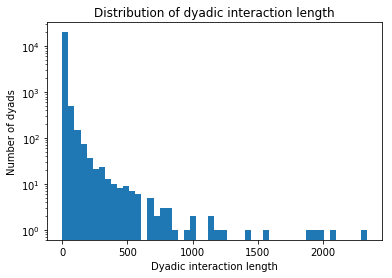

In [52]:
plt.hist(dyadic_int_counter.values(), log=True, bins=50)
plt.title("Distribution of dyadic interaction length")
plt.xlabel("Dyadic interaction length")
plt.ylabel("Number of dyads")
plt.show()

In [53]:
np.sum(np.array(list(dyadic_int_counter.values())) >= 10) / len(dyadic_int_counter)

0.22609652269574784

In [54]:
np.sum(np.array(list(dyadic_int_counter.values())) >= 2) / len(dyadic_int_counter)

0.6964652987037834

In [55]:
np.mean(np.array(list(dyadic_int_counter.values()))), np.median(np.array(list(dyadic_int_counter.values())))

(12.433730329554695, 3.0)

In [56]:
13896060 in set(site_df.site_id)

False

In [57]:
journal_subset = journal_df[journal_df.site_id.isin(valid_site_ids)][['site_id', 'journal_oid', 'user_id', 'site_index', 'created_at']]
len(journal_subset)

12663744

In [58]:
len(journal_subset) / len(journal_df)

0.8461008121703079

In [59]:
journal_subset_filepath = os.path.join(working_dir, 'filtered_journal_updates.csv')
journal_subset.to_csv(journal_subset_filepath, index=False)
print("Finished.")

Finished.
